In [3]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion # for local neighborhoof
from scipy.ndimage.morphology import iterate_structure # for local neighborhood

from typing import Tuple, Callable, List
from typing import List, Tuple, Dict
from microphone import record_audio


%matplotlib notebook

In [31]:
class FingerprintKey:
    def __init__(self, key, ti):
        self.key = key # (fi, fj, delta_t)
        self.ti = ti

class SongRecord:
    def __init__(self, song, ti):
        self.song = song
        self.ti = ti

def load_audio(song_name):
    '''
    Return the recorded audio and sampling_rate as a Tuple
    '''

    #length = 60  # seconds

    length = 10
    
    return librosa.load(song_name, sr = 44100, duration = length)




def get_spectrogram(recorded_audio, sampling_rate):
    '''
    Return the spectrogram corresponding to `recorded_audio` with `sampling_rate` as the sampling_rate
    '''
   
    return mlab.specgram(recorded_audio,
                            NFFT=4096,
                            Fs=sampling_rate,
                            window=mlab.window_hanning,
                            noverlap=4096//2,
                            mode='magnitude')

# make list "peaks" of all peaks, iterate through them with a fanout value and constructa fingerprint
def construct_fingerprint(peaks: List[Tuple[int, int]]) -> List[FingerprintKey]:
    
    #IMPORTANT: need to find the index for the first peak in our temporal window and start iterating from there

    """
    Parameters
    ----------
    peak: List of tuples for peak location, the first value 
    being the peak and the second value being 
    the time at which it occured. 

    peak is the output of  local_peak_locations

    Returns
    -------
    A list of FingerPrintKey objects that make up the whole fingerprint for some peak. This list will be stored in
    the database through the function put_database

    """

    fanout = 15
    fingerprint = []
    start_index = 0 #need to find the index for the first peak in our temporal window and start iterating from there
    
    # find location of first peak in the list

    for i in range(start_index + 1, start_index + fanout + 1):
    
        # compare peak time to the next 15 peaks
        abs_time = peaks[start_index][1] # the time of the first peak recorded
        peak, time = peaks[i]
        next_peak, next_time = peaks[i + 1]
        _print = FingerprintKey((peak, next_peak, next_time - abs_time), abs_time)
        fingerprint.append(_print)
    
    return fingerprint 

def put_database(fingerprint_database: Dict[FingerprintKey, List[SongRecord]], song_database: List[SongRecord], fingerprint: FingerprintKey, song: SongRecord):
    '''
    Put a song and fingerprint in the database
    '''
    if fingerprint.key not in fingerprint_database:
        fingerprint_database[fingerprint.key] = []
    fingerprint_database[fingerprint.key].append(song)
    song_database.append(song)

def fill_database(song_names: List[str], fingerprint_database: Dict[FingerprintKey, SongRecord], song_database: List[SongRecord]):
    '''
    Fill the database
    '''
    for s in range(len(song_names)):
        recorded_audio, sampling_rate = load_audio(song_names.song)
        spectrogram = get_spectrogram(recorded_audio, sampling_rate)
        cutoff = get_cutoff(spectrogram)
        peaks = local_peaks_mask(spectrogram, cutoff)
        fingerprint_keys = construct_fingerprint(peaks)
        for fingerprint in fingerprint_keys:
            sr = SongRecord(s, fingerprint.ti)
            put_database(fingerprint_database, song_database, fingerprint, sr)

def get_cutoff(S):
    '''
    Get cutoff of spectrogram
    '''
    log_S = np.log(S).ravel()  # flattened array
    ind = round(len(log_S) * 0.75)
    cutoff_log_amplitude = np.partition(log_S, ind)[ind]
    return np.exp(cutoff_log_amplitude)
    

In [18]:

recorded_audio, sampling_rate = load_audio('songs/Walking On The Sun.mp3')


/Users/shrutisharma/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [6]:
spectrogram, freqs, times =  get_spectrogram(recorded_audio, sampling_rate)

spectrogram

array([[8.87107612e-07, 0.00000000e+00, 0.00000000e+00, ...,
        1.46756188e-05, 9.13904678e-03, 1.58272748e-02],
       [1.19353138e-06, 0.00000000e+00, 0.00000000e+00, ...,
        7.23378877e-04, 5.45579476e-03, 9.00106826e-03],
       [1.81196147e-06, 0.00000000e+00, 0.00000000e+00, ...,
        7.65367733e-04, 8.60919976e-04, 1.40475028e-03],
       ...,
       [1.36476440e-08, 0.00000000e+00, 0.00000000e+00, ...,
        1.51268322e-06, 1.66270734e-05, 1.40604852e-05],
       [1.21534194e-08, 0.00000000e+00, 0.00000000e+00, ...,
        1.54029038e-06, 2.22145782e-05, 1.34763497e-05],
       [1.19805131e-08, 0.00000000e+00, 0.00000000e+00, ...,
        1.75502805e-06, 2.19116727e-05, 1.33244733e-05]])

In [ ]:
np.max(samples)

In [ ]:
from IPython.display import Audio
Audio(recorded_audio, rate = sampling_rate)

In [ ]:
sampling_rate

<IPython.core.display.Javascript object>


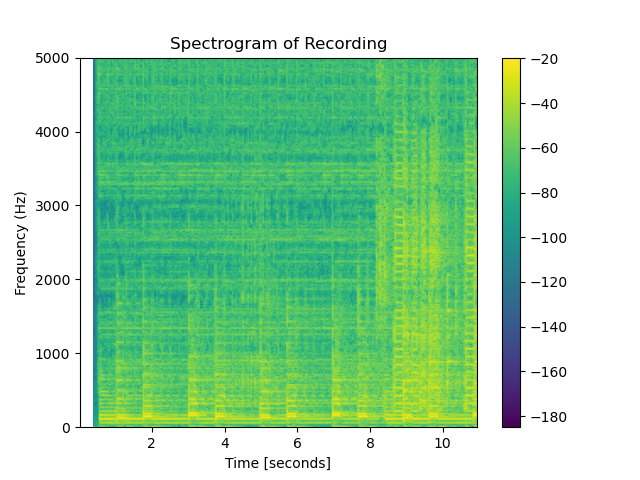

(0.0, 5000.0)

In [24]:
import matplotlib.mlab as mlab

fig, ax = plt.subplots()

S, freqs, times, im = ax.specgram(
    recorded_audio,
    NFFT=4096,
    Fs=sampling_rate,
    window=mlab.window_hanning,
    noverlap=4096 // 2,
    mode='magnitude',
    scale="dB"
)
fig.colorbar(im)

ax.set_xlabel("Time [seconds]")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Recording")
ax.set_ylim(0, 5000)

<IPython.core.display.Javascript object>


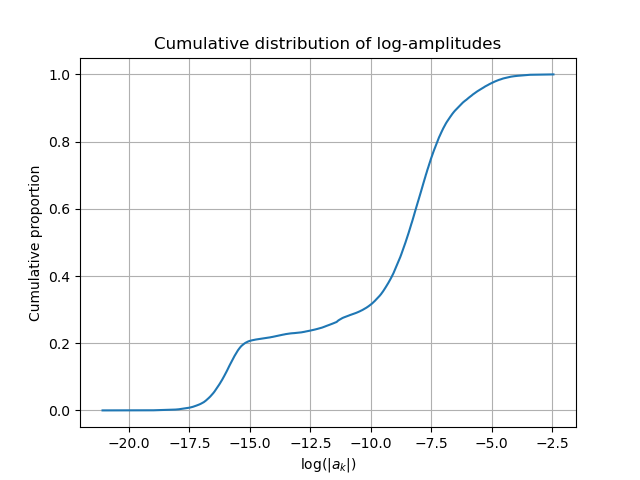

[-21.09540601 -20.4665535  -20.40367967 ...  -2.48716168  -2.46614055
  -2.44814707]
[8.41453358e-06 1.68290672e-05 2.52436007e-05 ... 9.99983171e-01
 9.99991585e-01 1.00000000e+00]


In [8]:
import numpy as np

def ecdf(data):
    """Returns (x) the sorted data and (y) the empirical cumulative-proportion
    of each datum.
    
    Parameters
    ----------
    data : numpy.ndarray, size-N
    
    Returns
    -------
    Tuple[numpy.ndarray shape-(N,), numpy.ndarray shape-(N,)]
        Sorted data, empirical CDF values"""
    data = np.asarray(data).ravel()  # flattens the data
    y = np.linspace(1 / len(data), 1, len(data))  # stores the cumulative proportion associated with each sorted datum
    x = np.sort(data)
    return x, y
fig, ax = plt.subplots()

x, y = ecdf(np.log(S))
print(x)
print(y)
ax.plot(x, y)

ax.set_xlabel(r"$\log(|a_{k}|)$")
ax.set_ylabel(r"Cumulative proportion")
ax.set_title("Cumulative distribution of log-amplitudes")
ax.grid(True)



In [9]:
log_S = np.log(S).ravel()  # flattened array
ind = round(len(log_S) * 0.75)
cutoff_log_amplitude = np.partition(log_S, ind)[ind]
cutoff_log_amplitude

-7.508554347486261

In [10]:
np.exp(-7.268590067208814)

0.0006970941571156986

In [29]:
from numba import njit

# `@njit` "decorates" the `_peaks` function. This tells Numba to
# compile this function using the "low level virtual machine" (LLVM)
# compiler. The resulting object is a Python function that, when called,
# executes optimized machine code instead of the Python code
# 
# The code used in _peaks adheres strictly to the subset of Python and
# NumPy that is supported by Numba's jit. This is a requirement in order
# for Numba to know how to compile this function to more efficient
# instructions for the machine to execute
@njit
def _peaks(
    data_2d: np.ndarray, rows: np.ndarray, cols: np.ndarray, amp_min: float
) -> List[Tuple[int, int]]:
    """
    A Numba-optimized 2-D peak-finding algorithm.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected.

    rows : numpy.ndarray, shape-(N,)
        The 0-centered row indices of the local neighborhood mask
    
    cols : numpy.ndarray, shape-(N,)
        The 0-centered column indices of the local neighborhood mask
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location. 
    """
    peaks = []  # stores the (row, col) locations of all the local peaks

    # Iterate over the 2-D data in col-major order
    # we want to see if there is a local peak located at
    # row=r, col=c

    for c, r in np.ndindex(*data_2d.shape[::-1]):
        if data_2d[r, c] <= amp_min:
            # The amplitude falls beneath the minimum threshold
            # thus this can't be a peak.
            continue
        
        # Iterating over the neighborhood centered on (r, c)
        # dr: displacement from r
        # dc: discplacement from c
        for dr, dc in zip(rows, cols):
            if dr == 0 and dc == 0:
                # This would compare (r, c) with itself.. skip!
                continue

            if not (0 <= r + dr < data_2d.shape[0]):
                # neighbor falls outside of boundary
                continue

            # mirror over array boundary
            if not (0 <= c + dc < data_2d.shape[1]):
                # neighbor falls outside of boundary
                continue

            if data_2d[r, c] < data_2d[r + dr, c + dc]:
                # One of the amplitudes within the neighborhood
                # is larger, thus data_2d[r, c] cannot be a peak
                break
        else:
            # if we did not break from the for-loop then (r, c) is a peak
            peaks.append((r, c))
    return peaks

# `local_peak_locations` is responsible for taking in the boolean mask `neighborhood`
# and converting it to a form that can be used by `_peaks`. This "outer" code is 
# not compatible with Numba which is why we end up using two functions:
# `local_peak_locations` does some initial pre-processing that is not compatible with
# Numba, and then it calls `_peaks` which contains all of the jit-compatible code
def local_peak_locations(data_2d: np.ndarray, neighborhood: np.ndarray, amp_min: float):
    """
    Defines a local neighborhood and finds the local peaks
    in the spectrogram, which must be larger than the specified `amp_min`.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected
    
    neighborhood : numpy.ndarray, shape-(h, w)
        A boolean mask indicating the "neighborhood" in which each
        datum will be assessed to determine whether or not it is
        a local peak. h and w must be odd-valued numbers
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location.
    
    Notes
    -----
    Neighborhoods that overlap with the boundary are mirrored across the boundary.
    
    The local peaks are returned in column-major order.
    """
    
    rows, cols = np.where(neighborhood)
    
    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1

    # center neighborhood indices around center of neighborhood
    rows -= neighborhood.shape[0] // 2
    
    cols -= neighborhood.shape[1] // 2
    

    return _peaks(data_2d, rows, cols, amp_min=amp_min)

In [ ]:
np.max(S)

In [28]:
def local_peaks_mask(data: np.ndarray, cutoff: float) -> np.ndarray:
    """Find local peaks in a 2D array of data.

    Parameters
    ----------
    data : numpy.ndarray, shape-(H, W)

    cutoff : float
         A threshold value that distinguishes background from foreground

    Returns
    -------
    Binary indicator, of the same shape as `data`. The value of
    1 indicates a local peak."""
    # Generate a rank-2, connectivity-2 binary mask
    neighborhood_mask = generate_binary_structure(rank = 2, connectivity = 1)  # <COGLINE>
    

    # Use that neighborhood to find the local peaks in `data`.
    # Pass `cutoff` as `amp_min` to `local_peak_locations`.
    peak_locations = local_peak_locations(data, neighborhood_mask, cutoff)  # <COGLINE>
   
    

    # Turns the list of (row, col) peak locations into a shape-(N_peak, 2) array
    # Save the result to the variable `peak_locations`
    #peak_locations = np.array(peak_locations)

    # create a mask of zeros with the same shape as `data`
    
    #mask = np.zeros(data.shape, dtype=bool)

    # populate the local peaks with `1`
    #mask[peak_locations[:, 0], peak_locations[:, 1]] = 1
    return peak_locations

In [ ]:
np.max(samples)

In [ ]:
np.exp(-8.78)

In [26]:
local_peaks_mask(spectrogram, 0)

[(28, 11),
 (43, 11),
 (46, 11),
 (57, 11),
 (61, 11),
 (66, 11),
 (71, 11),
 (75, 11),
 (78, 11),
 (129, 11),
 (304, 11),
 (316, 11),
 (320, 11),
 (330, 11),
 (345, 11),
 (388, 11),
 (407, 11),
 (418, 11),
 (423, 11),
 (429, 11),
 (439, 11),
 (442, 11),
 (449, 11),
 (452, 11),
 (459, 11),
 (488, 11),
 (506, 11),
 (530, 11),
 (539, 11),
 (562, 11),
 (565, 11),
 (570, 11),
 (575, 11),
 (604, 11),
 (609, 11),
 (612, 11),
 (615, 11),
 (619, 11),
 (631, 11),
 (633, 11),
 (642, 11),
 (645, 11),
 (658, 11),
 (668, 11),
 (684, 11),
 (689, 11),
 (693, 11),
 (709, 11),
 (713, 11),
 (717, 11),
 (721, 11),
 (723, 11),
 (728, 11),
 (731, 11),
 (734, 11),
 (740, 11),
 (742, 11),
 (745, 11),
 (755, 11),
 (761, 11),
 (766, 11),
 (776, 11),
 (789, 11),
 (803, 11),
 (823, 11),
 (827, 11),
 (829, 11),
 (834, 11),
 (844, 11),
 (861, 11),
 (876, 11),
 (906, 11),
 (920, 11),
 (949, 11),
 (952, 11),
 (955, 11),
 (959, 11),
 (967, 11),
 (976, 11),
 (980, 11),
 (982, 11),
 (1001, 11),
 (1003, 11),
 (1006, 11)

In [ ]:
for s in range(len(song_names)):
    N = len(f_t_values[s])
    #song_name = song_names[s]
    for i in range(N):
        for j in range(1, fanout+1):
            if i+j >= N:
                break
            f_i = f_t_values[s][i]
            f_j = f_t_values[s][i+j]

            dt = f_j[1] - f_i[1]
            key = (f_i[0], f_j[0], dt)
            fpk = FingerprintKey(key, f_i[1]) # fingerprint key
            sr = SongRecord(song_name, f_i[1]) # song record
            
            put_database(database, song_database, fpk, sr)